In [63]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,RepeatVector,Bidirectional,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd 
import numpy as np

In [64]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [65]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [66]:
data = read_text("heb.txt")
deu_eng = to_lines(data)
deu_eng = np.array(deu_eng)

In [67]:
deu_eng = deu_eng[:50000,:]

In [68]:
deu_eng

array([['Hi.', 'היי.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #694680 (Eldad)'],
       ['Hi.', 'אהלן.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #2184365 (MrShoval)'],
       ['Run!', 'רוץ!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2805053 (Eldad)'],
       ...,
       ["You're definitely crazy.", 'אתם בוודאות משוגעים.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2545659 (CK) & #4676062 (fekundulo)'],
       ["You're definitely crazy.", 'את בוודאות משוגעת.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2545659 (CK) & #4676064 (fekundulo)'],
       ["You're driving me crazy.", 'את מטריפה אותי.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1895620 (CK) & #5820028 (fekundulo)']],
      dtype='<U286')

In [69]:
import string
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [70]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [71]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [72]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

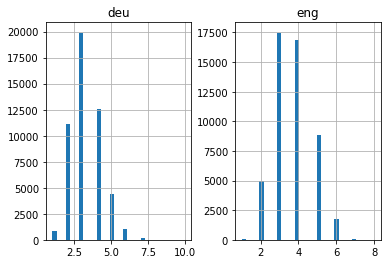

In [74]:
length_df.hist(bins = 30)
plt.show()

In [75]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [76]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 7407


In [77]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Arabic Vocabulary Size: %d' % deu_vocab_size)

Arabic Vocabulary Size: 17905


In [78]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [79]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [80]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [81]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [82]:
model = Sequential()
model.add(Embedding(deu_vocab_size, 512, input_length=deu_length, mask_zero=True))
model.add(LSTM(512))
model.add(RepeatVector(deu_length))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(eng_vocab_size, activation='softmax'))

In [83]:
model.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy')

In [84]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.20)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 163s 5ms/step - loss: 3.6403 - val_loss: 3.0067
Epoch 2/30
32000/32000 [==============================] - 156s 5ms/step - loss: 2.9258 - val_loss: 2.9323
Epoch 3/30
32000/32000 [==============================] - 161s 5ms/step - loss: 2.7864 - val_loss: 2.7763
Epoch 4/30
32000/32000 [==============================] - 173s 5ms/step - loss: 2.6260 - val_loss: 2.6716
Epoch 5/30
32000/32000 [==============================] - 181s 6ms/step - loss: 2.4706 - val_loss: 2.5312
Epoch 6/30
32000/32000 [==============================] - 182s 6ms/step - loss: 2.3256 - val_loss: 2.4320
Epoch 7/30
32000/32000 [==============================] - 172s 5ms/step - loss: 2.1890 - val_loss: 2.3781
Epoch 8/30
32000/32000 [==============================] - 165s 5ms/step - loss: 2.0686 - val_loss: 2.3025
Epoch 9/30
32000/32000 [==============================] - 162s 5ms/step - loss: 1.9596 - val_loss: 2.23

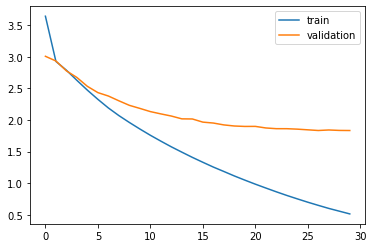

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [86]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [87]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [88]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [89]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [90]:
pd.set_option('display.max_colwidth', 200)

In [91]:
pred_df.head(15)

,actual,predicted
0,the theater is empty,the empty
1,come again,come again
2,tom remembers,tom remembered
3,pick any card,show me another
4,this is very dangerous,its very dangerous
5,do you know each other,do you know your
6,do you think i need one,do you think i need one
7,i want to speak german,i want to speak an
8,they all scoffed,they all nuts
9,its a daunting agenda,its a day


In [92]:
pred_df.tail(15)

,actual,predicted
9985,are you kidding me,you me
9986,dont oppose him,dont let her
9987,youre introverted,youre awesome
9988,why dont we all go,why dont we just
9989,they already left,they left
9990,i like your coffee,i like your coffee
9991,is that too much,is this that
9992,turn right,turn it over
9993,fortune smiled on him,the baby laughed
9994,keep paging tom,stay on tom
